# Preprocessing and clustering 3k PBMCs: umap-learn 0.5.2

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.
    
The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [ ]:
!pip install -q scanpy
!pip install -q leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.7 MB/s eta 0:00:00


In [ ]:
import umap
umap.__version__

'0.5.3'

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.4.4 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [ ]:
import pickle

# Load the AnnData object from the file
with open('adata.pickle', 'rb') as f:
    adata = pickle.load(f)

In [ ]:
adata

AnnData object with n_obs × n_vars = 2711 × 98319
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [ ]:
print(adata.X[:10,:10])

  (7, 3)	2.0
  (8, 0)	2.0


In [ ]:
adata.var

gene_ids feature_types  genome  \
chr1:9768-10660                chr1:9768-10660         Peaks  GRCh38   
chr1:180582-181297          chr1:180582-181297         Peaks  GRCh38   
chr1:181404-181887          chr1:181404-181887         Peaks  GRCh38   
chr1:191175-192089          chr1:191175-192089         Peaks  GRCh38   
chr1:267561-268455          chr1:267561-268455         Peaks  GRCh38   
...                                        ...           ...     ...   
KI270726.1:41489-42329  KI270726.1:41489-42329         Peaks  GRCh38   
KI270713.1:3949-4854      KI270713.1:3949-4854         Peaks  GRCh38   
KI270713.1:21434-22339  KI270713.1:21434-22339         Peaks  GRCh38   
KI270713.1:29578-30400  KI270713.1:29578-30400         Peaks  GRCh38   
KI270713.1:36917-37831  KI270713.1:36917-37831         Peaks  GRCh38   

                                      interval  
chr1:9768-10660                chr1:9768-10660  
chr1:180582-181297          chr1:180582-181297  
chr1:181404-181887          chr1:181404-181887  
chr1:191175-192089          chr1:191175-192089  
chr1:267561-268455          chr1:267561-268455  
...                                        ...  
KI270726.1:41489-42329  KI270726.1:41489-42329  
KI270713.1:3949-4854      KI270713.1:3949-4854  
KI270713.1:21434-22339  KI270713.1:21434-22339  
KI270713.1:29578-30400  KI270713.1:29578-30400  
KI270713.1:36917-37831  KI270713.1:36917-37831  

[98319 rows x 4 columns]

In [ ]:
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)
print(adata.shape)

filtered out 67362 genes that are detected in less than 135 cells
(2711, 30957)


In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

Gene expression data

In [ ]:
# Load the AnnData object from the file
with open('cdata.pickle', 'rb') as f:
    cdata = pickle.load(f)

In [ ]:
cdata

AnnData object with n_obs × n_vars = 2711 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [ ]:
cdata.var

gene_ids    feature_types  genome  \
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38   
FAM138A      ENSG00000237613  Gene Expression  GRCh38   
OR4F5        ENSG00000186092  Gene Expression  GRCh38   
AL627309.1   ENSG00000238009  Gene Expression  GRCh38   
AL627309.3   ENSG00000239945  Gene Expression  GRCh38   
...                      ...              ...     ...   
AC141272.1   ENSG00000277836  Gene Expression  GRCh38   
AC023491.2   ENSG00000278633  Gene Expression  GRCh38   
AC007325.1   ENSG00000276017  Gene Expression  GRCh38   
AC007325.4   ENSG00000278817  Gene Expression  GRCh38   
AC007325.2   ENSG00000277196  Gene Expression  GRCh38   

                               interval  
MIR1302-2HG            chr1:29553-30267  
FAM138A                chr1:36080-36081  
OR4F5                  chr1:65418-69055  
AL627309.1           chr1:120931-133723  
AL627309.3             chr1:91104-91105  
...                                 ...  
AC141272.1   KI270728.1:1270983-1270984  
AC023491.2       KI270731.1:13000-13001  
AC007325.1       KI270734.1:72410-72411  
AC007325.4     KI270734.1:131493-131494  
AC007325.2     KI270734.1:161749-161852  

[36601 rows x 4 columns]

In [ ]:
cdata.var_names_make_unique()

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


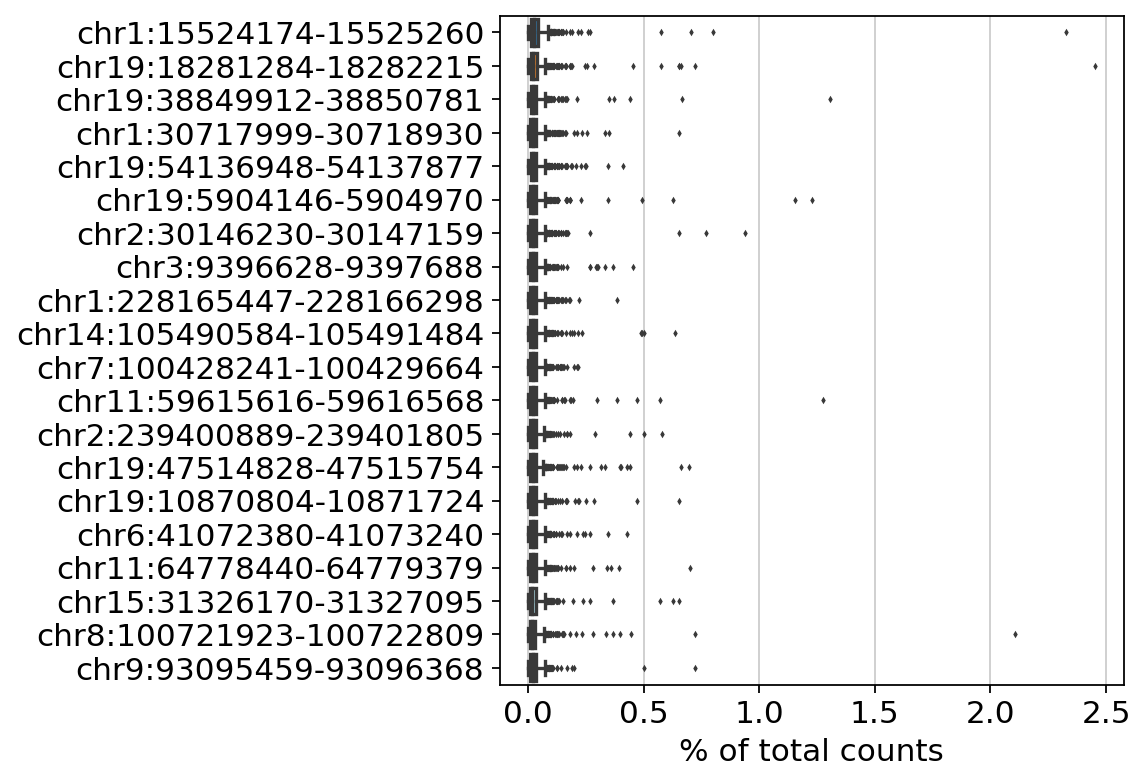

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 35 cells that have less than 200 genes expressed


Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [ ]:
# adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

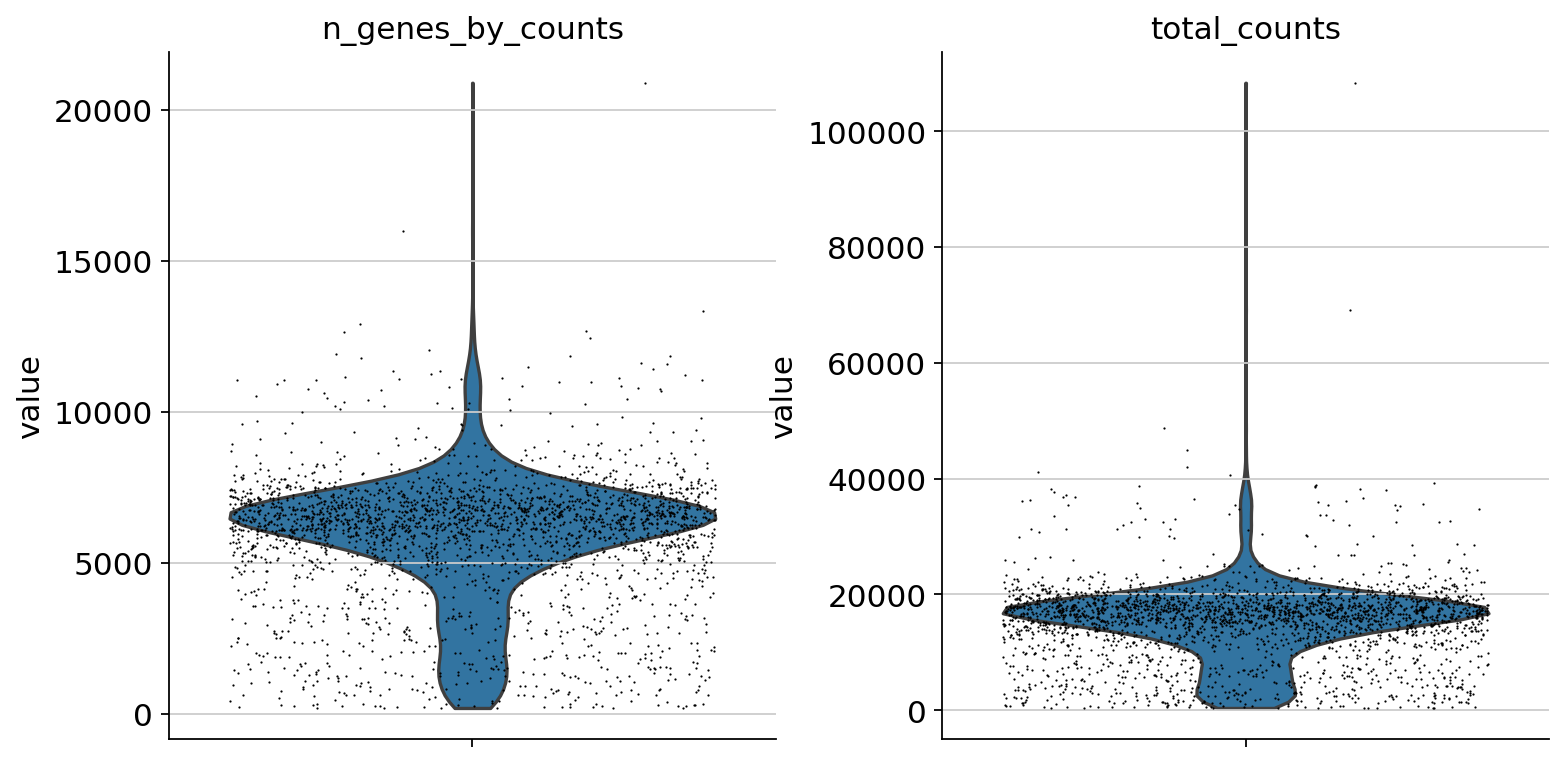

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

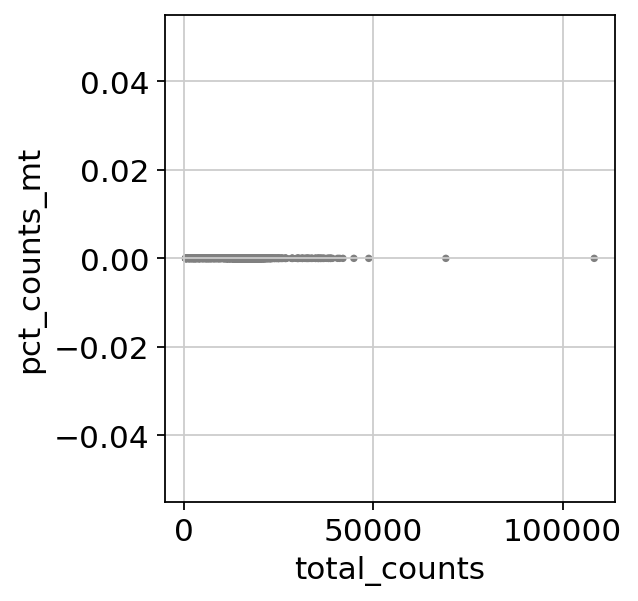

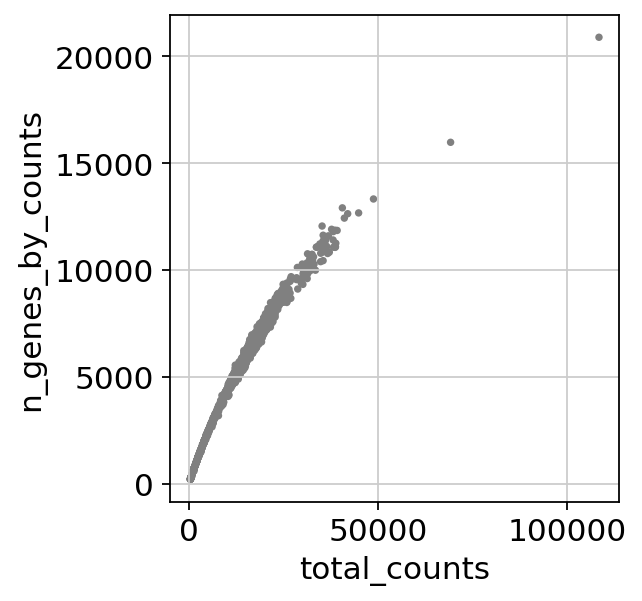

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Actually do the filtering by slicing the `AnnData` object.

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 15000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 2674 × 30957
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


Logarithmize the data:

In [ ]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


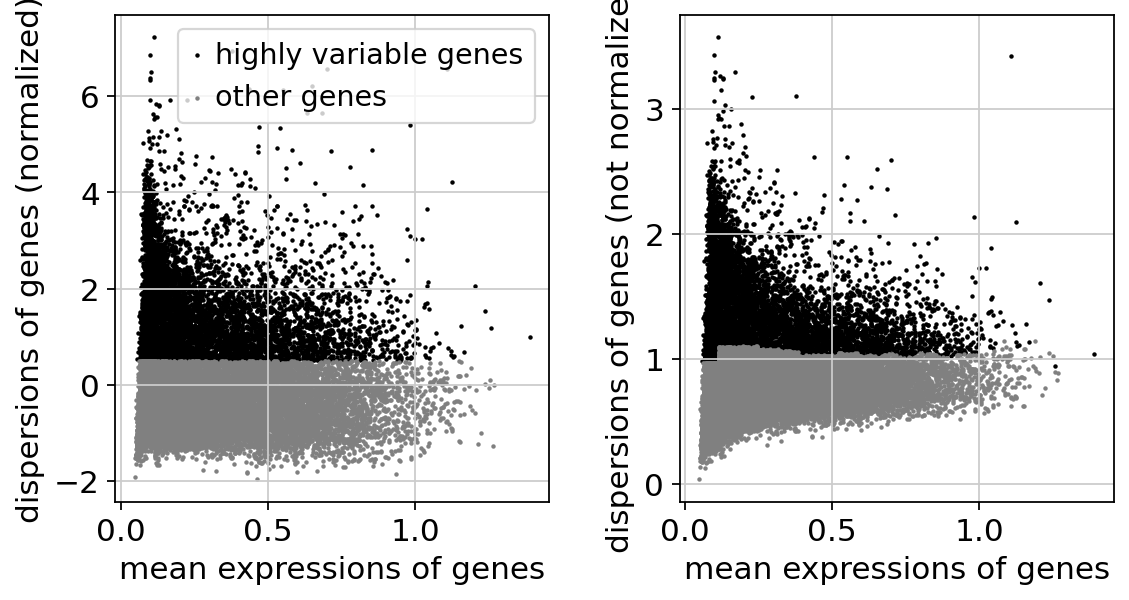

In [ ]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

<div class="alert alert-info">

**Note**

You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

</div>    

In [ ]:
adata.raw = adata

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Actually do the filtering

In [ ]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:45)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [ ]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


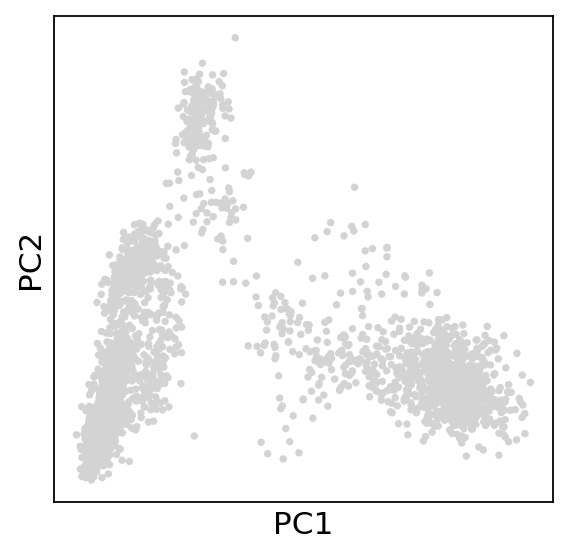

In [ ]:
sc.pl.pca(adata)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

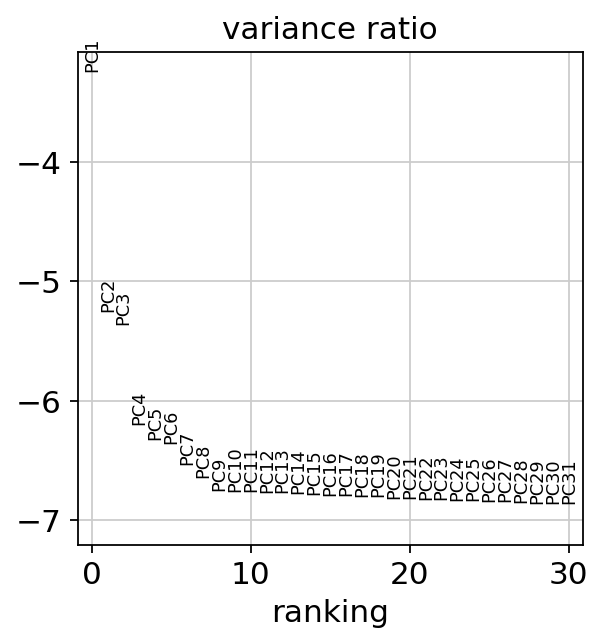

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [ ]:
adata.write('results_file')

In [ ]:
adata

AnnData object with n_obs × n_vars = 2674 × 6889
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


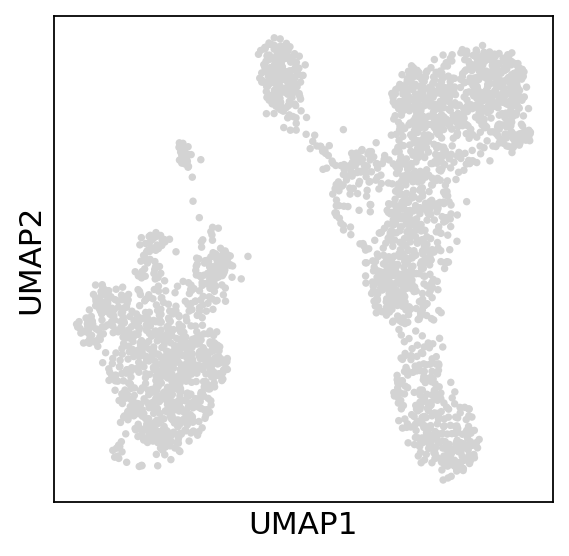

In [ ]:
sc.pl.umap(adata)

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [ ]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


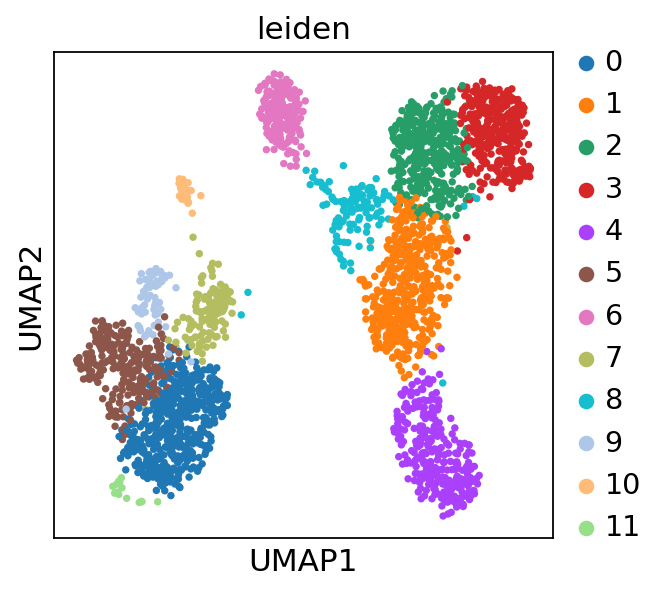

In [ ]:
sc.pl.umap(adata,color=['leiden'],save='.jpg')


Save the result.

In [ ]:
adata.write('results_file')

## scRNA seq analysis

normalizing counts per cell
    finished (0:00:00)


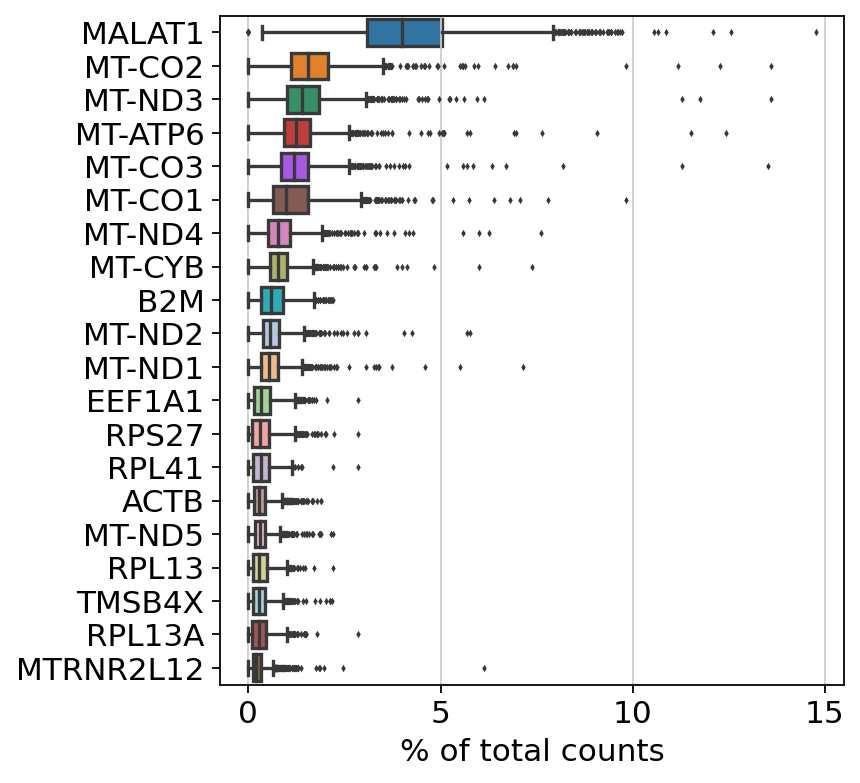

In [ ]:
sc.pl.highest_expr_genes(cdata, n_top=20, )

In [ ]:
cdata.var['mt'] = cdata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(cdata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

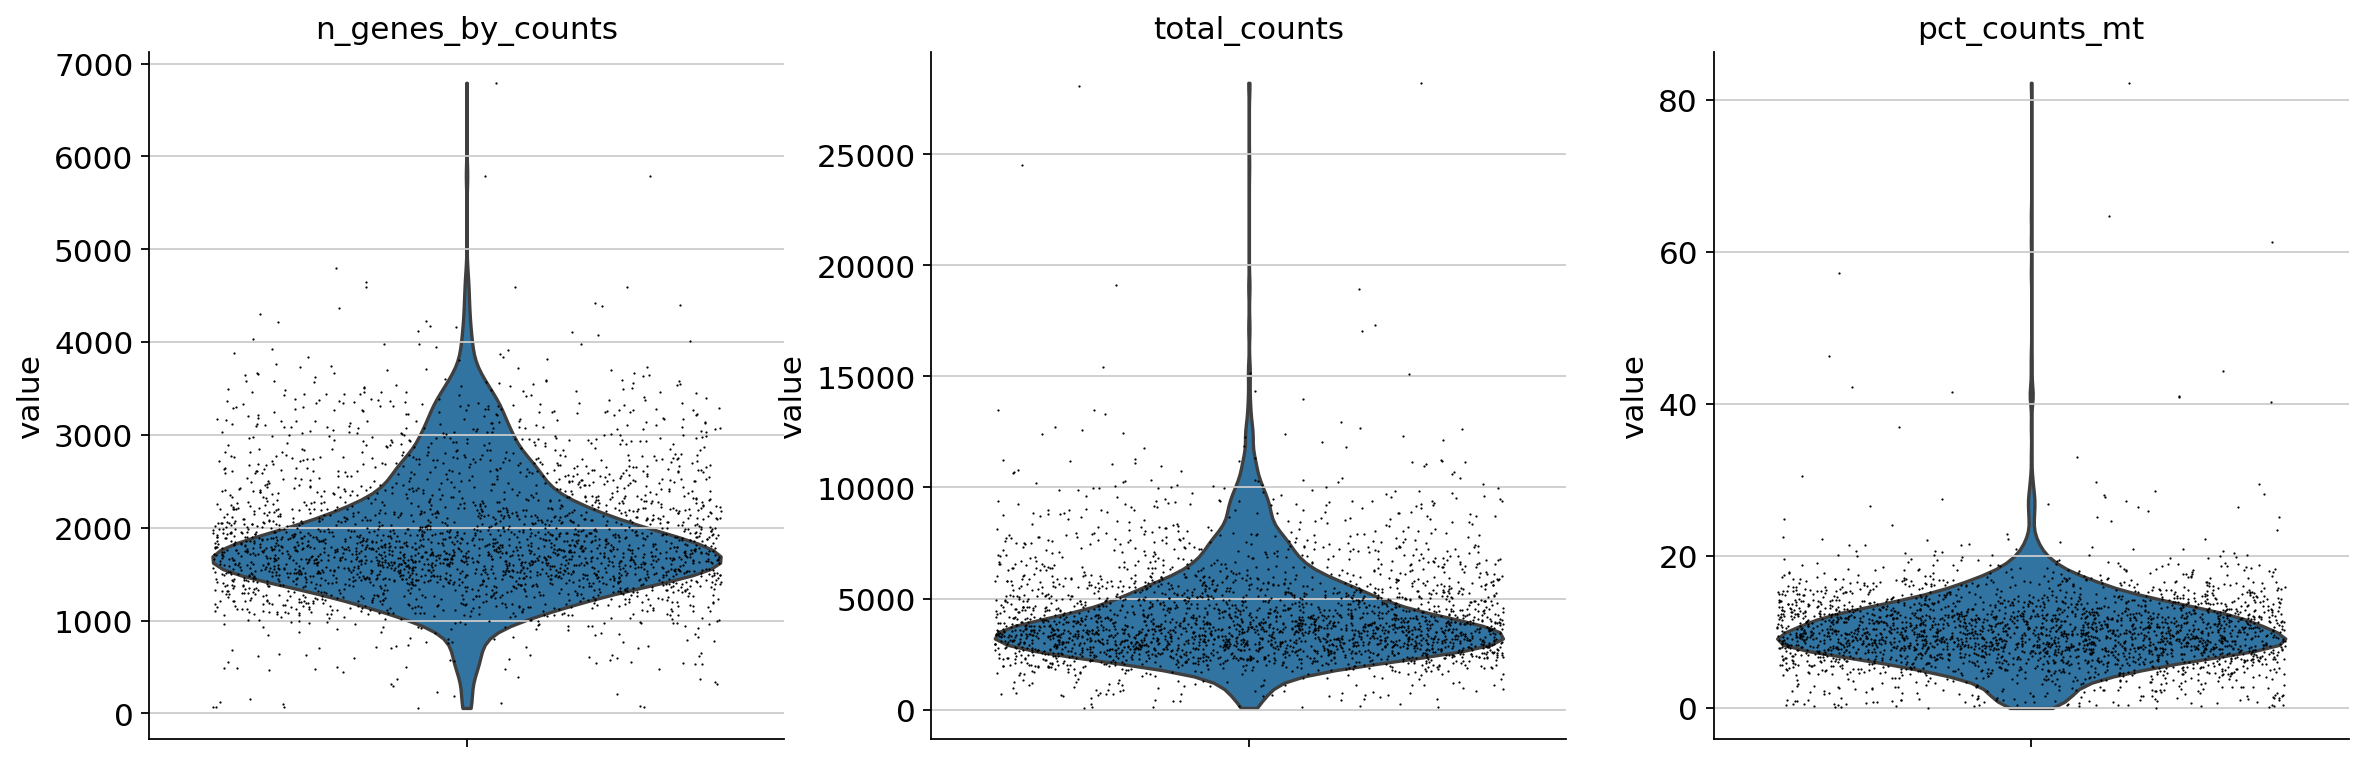

In [ ]:
sc.pl.violin(cdata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
cdata = cdata[cdata.obs.n_genes_by_counts < 15000, :]
cdata = cdata[cdata.obs.pct_counts_mt < 20, :]

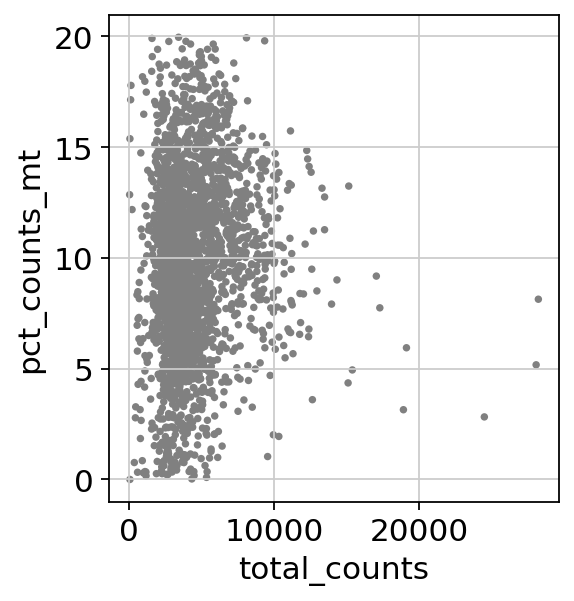

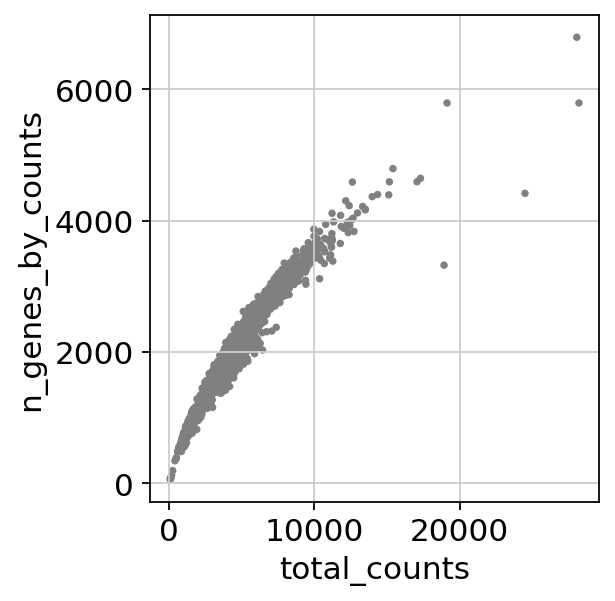

In [ ]:
sc.pl.scatter(cdata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(cdata, x='total_counts', y='n_genes_by_counts')

In [ ]:
sc.pp.normalize_total(cdata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
sc.pp.log1p(cdata)

In [ ]:
sc.pp.highly_variable_genes(cdata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


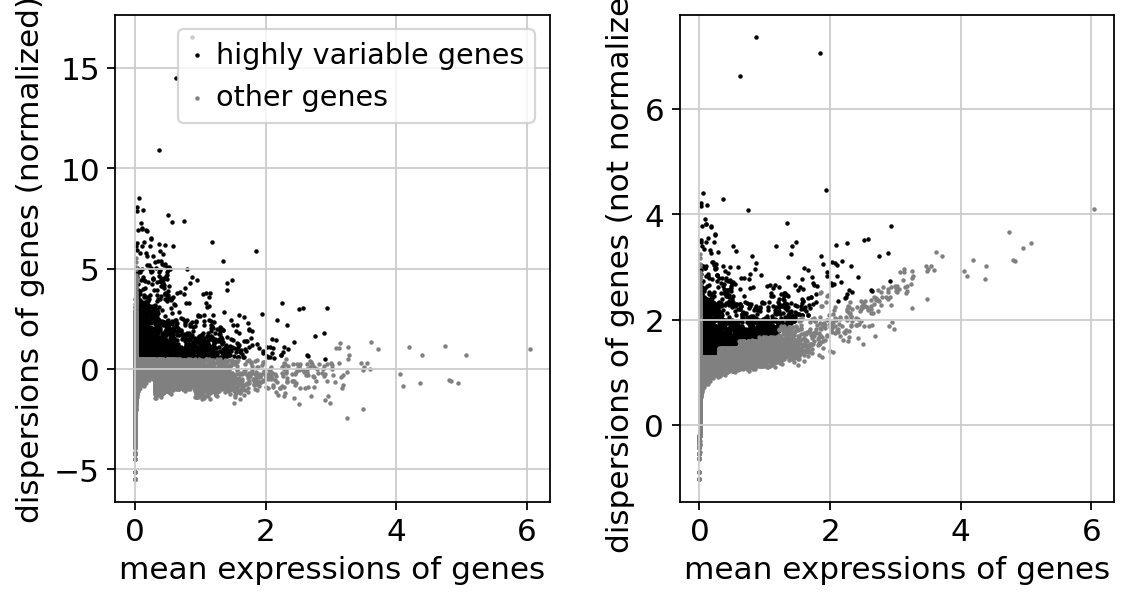

In [ ]:
sc.pl.highly_variable_genes(cdata)

In [ ]:
cdata.raw = cdata

In [ ]:
cdata = cdata[:, cdata.var.highly_variable]

In [ ]:
sc.pp.regress_out(cdata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:27)


In [ ]:
sc.pp.regress_out(cdata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:29)


In [ ]:
sc.pp.scale(cdata, max_value=10)

PCA

In [ ]:
sc.tl.pca(cdata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


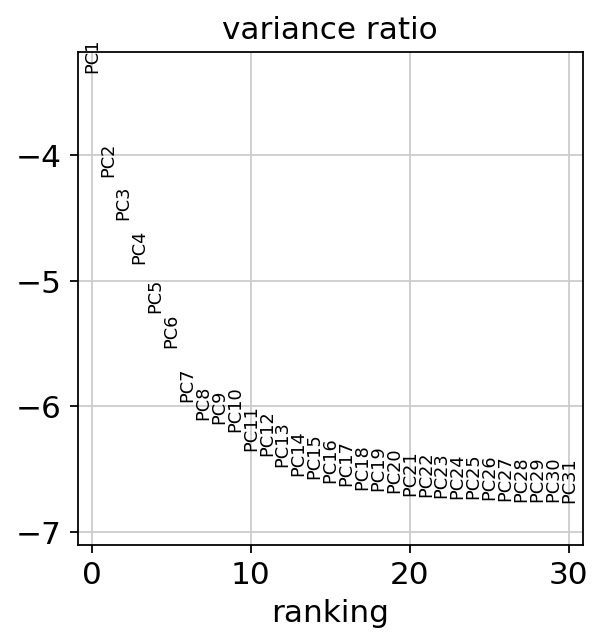

In [ ]:
sc.pl.pca_variance_ratio(cdata, log=True)

In [ ]:
cdata

AnnData object with n_obs × n_vars = 2652 × 4403
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'rank_genes_groups', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Neighbor

In [ ]:
sc.pp.neighbors(cdata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [ ]:
sc.tl.umap(cdata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


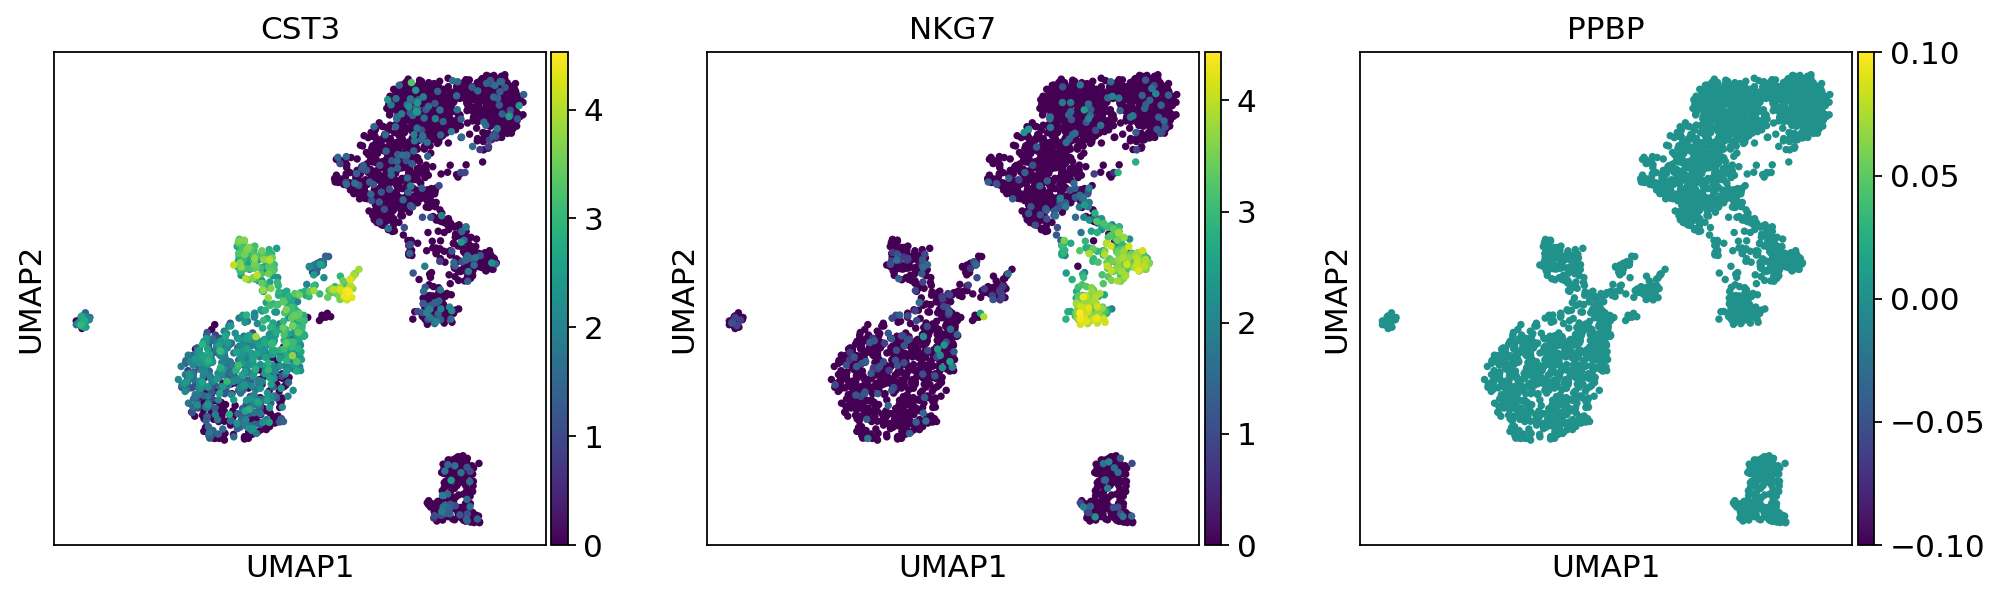

In [ ]:
sc.pl.umap(cdata, color=['CST3', 'NKG7', 'PPBP'])

Clustering the neighborhood graph

In [ ]:
sc.tl.leiden(cdata)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


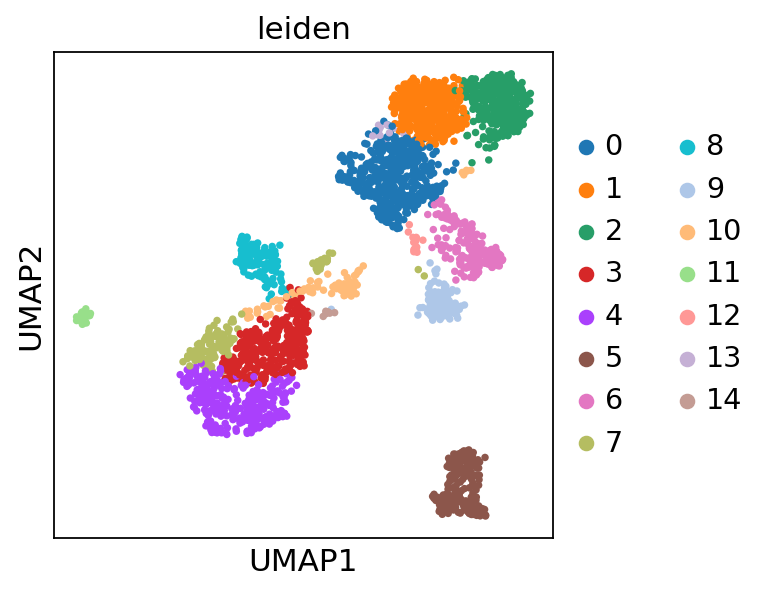

In [ ]:
sc.pl.umap(cdata, color=['leiden'])

In [ ]:
adata

AnnData object with n_obs × n_vars = 2674 × 6889
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
cdata

AnnData object with n_obs × n_vars = 2652 × 4403
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'rank_genes_groups', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


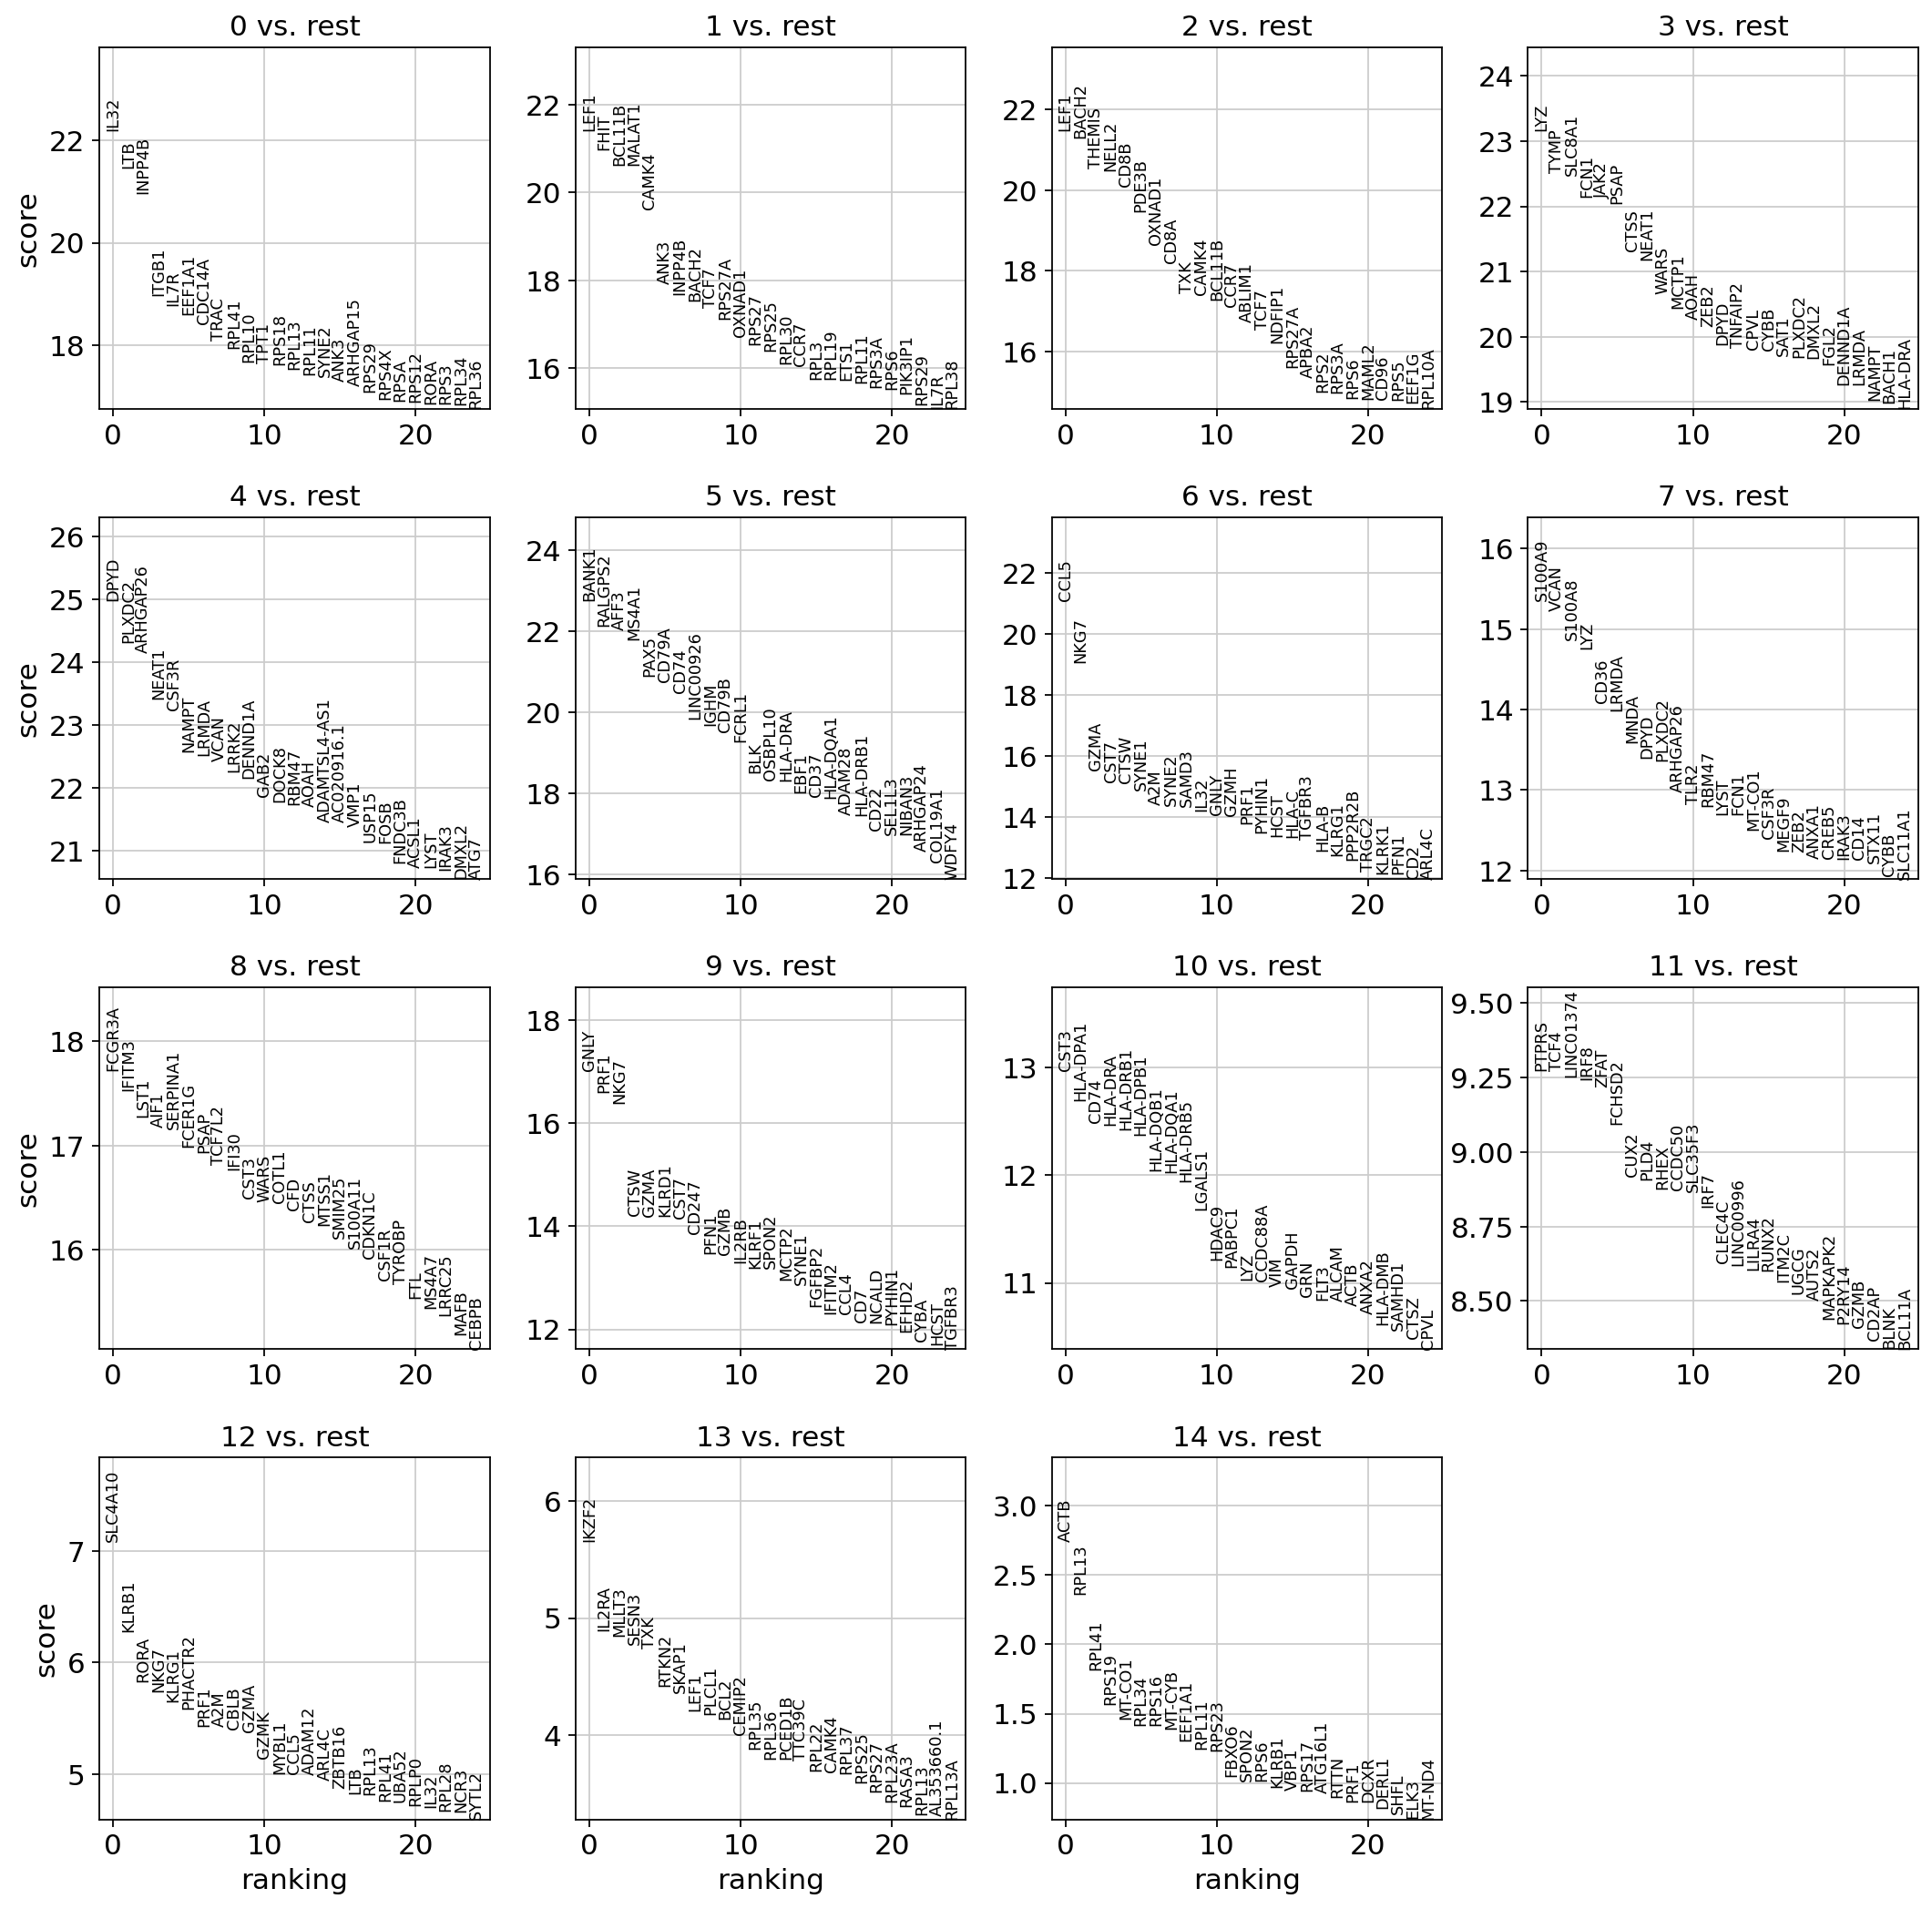

In [ ]:
sc.tl.rank_genes_groups(cdata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(cdata, n_genes=25, sharey=False)

Save the result.

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [ ]:
pd.DataFrame(cdata.uns['rank_genes_groups']['names']).head(25)

CD4 T(0) Naive CD4 T(1)       2 CD14 Monocytes(3)             4  \
0       IL32           LEF1    LEF1               LYZ          DPYD   
1        LTB           FHIT   BACH2              TYMP        PLXDC2   
2     INPP4B         BCL11B  THEMIS            SLC8A1      ARHGAP26   
3      ITGB1         MALAT1   NELL2              FCN1         NEAT1   
4       IL7R          CAMK4    CD8B              JAK2         CSF3R   
5     EEF1A1           ANK3   PDE3B              PSAP         NAMPT   
6     CDC14A         INPP4B  OXNAD1              CTSS         LRMDA   
7       TRAC          BACH2    CD8A             NEAT1          VCAN   
8      RPL41           TCF7     TXK              WARS         LRRK2   
9      RPL10         RPS27A   CAMK4             MCTP1       DENND1A   
10      TPT1         OXNAD1  BCL11B              AOAH          GAB2   
11     RPS18          RPS27    CCR7              ZEB2         DOCK8   
12     RPL13          RPS25  ABLIM1              DPYD         RBM47   
13     RPL11          RPL30    TCF7           TNFAIP2          AOAH   
14     SYNE2           CCR7  NDFIP1              CPVL  ADAMTSL4-AS1   
15      ANK3           RPL3  RPS27A              CYBB    AC020916.1   
16  ARHGAP15          RPL19   APBA2              SAT1          VMP1   
17     RPS29           ETS1    RPS2            PLXDC2         USP15   
18     RPS4X          RPL11   RPS3A             DMXL2          FOSB   
19      RPSA          RPS3A    RPS6              FGL2        FNDC3B   
20     RPS12           RPS6   MAML2           DENND1A         ACSL1   
21      RORA        PIK3IP1    CD96             LRMDA          LYST   
22      RPS3          RPS29    RPS5             NAMPT         IRAK3   
23     RPL34           IL7R   EEF1G             BACH1         DMXL2   
24     RPL36          RPL38  RPL10A           HLA-DRA          ATG7   

            B       NK CD14 Monocytes(7) FCGR3A+Mono or DC NK cell  \
0       BANK1     CCL5            S100A9            FCGR3A    GNLY   
1     RALGPS2     NKG7              VCAN            IFITM3    PRF1   
2        AFF3     GZMA            S100A8              LST1    NKG7   
3       MS4A1     CST7               LYZ              AIF1    CTSW   
4        PAX5     CTSW              CD36          SERPINA1    GZMA   
5       CD79A    SYNE1             LRMDA            FCER1G   KLRD1   
6        CD74      A2M              MNDA              PSAP    CST7   
7   LINC00926    SYNE2              DPYD            TCF7L2   CD247   
8        IGHM    SAMD3            PLXDC2             IFI30    PFN1   
9       CD79B     IL32          ARHGAP26              CST3    GZMB   
10      FCRL1     GNLY              TLR2              WARS   IL2RB   
11        BLK     GZMH             RBM47             COTL1   KLRF1   
12    OSBPL10     PRF1              LYST               CFD   SPON2   
13    HLA-DRA   PYHIN1              FCN1              CTSS   MCTP2   
14       EBF1     HCST            MT-CO1             MTSS1   SYNE1   
15       CD37    HLA-C             CSF3R            SMIM25  FGFBP2   
16   HLA-DQA1   TGFBR3             MEGF9           S100A11  IFITM2   
17     ADAM28    HLA-B              ZEB2            CDKN1C    CCL4   
18   HLA-DRB1    KLRG1             ANXA1             CSF1R     CD7   
19       CD22  PPP2R2B             CREB5            TYROBP   NCALD   
20     SEL1L3    TRGC2             IRAK3               FTL  PYHIN1   
21     NIBAN3    KLRK1              CD14             MS4A7   EFHD2   
22   ARHGAP24     PFN1             STX11            LRRC25    CYBA   
23    COL19A1      CD2              CYBB              MAFB    HCST   
24      WDFY4    ARL4C           SLC11A1             CEBPB  TGFBR3   

   CD14 Monocytes or DC         11 NK cell(12)          13       14  
0                  CST3      PTPRS     SLC4A10       IKZF2     ACTB  
1              HLA-DPA1       TCF4       KLRB1       IL2RA    RPL13  
2                  CD74  LINC01374        RORA       MLLT3    RPL41  
3               HLA-DRA       IRF8        NKG7       SES

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


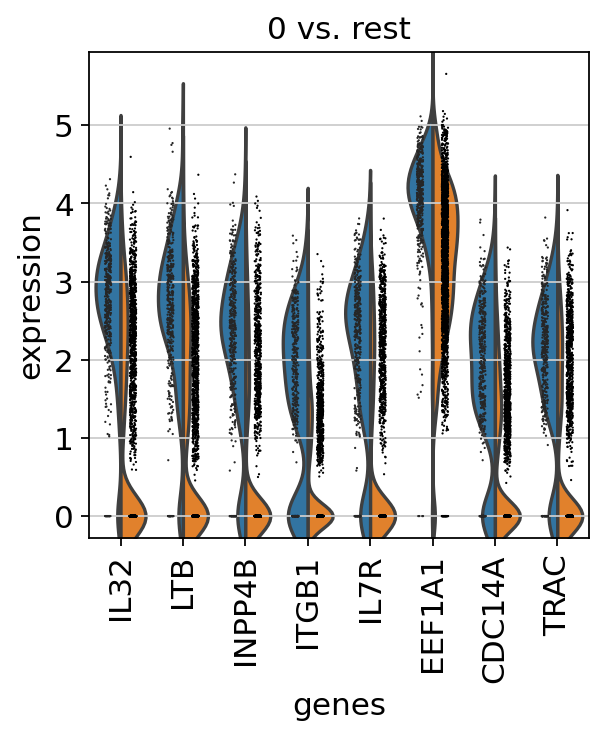

In [ ]:
sc.pl.rank_genes_groups_violin(cdata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

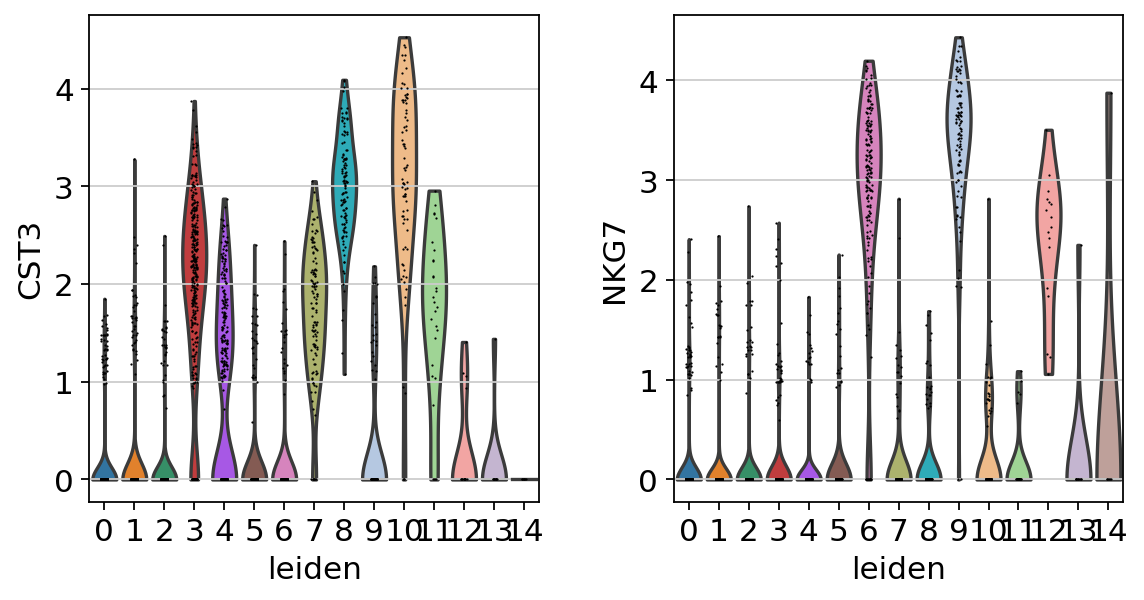

In [ ]:
sc.pl.violin(cdata, ['CST3', 'NKG7'], groupby='leiden')

Actually mark the cell types.

In [ ]:
new_cluster_names = [
    'CD4 T(0)','Naive CD4 T(1)','2','CD14 Monocytes(3)','4','B','NK','CD14 Monocytes(7)','FCGR3A+Mono','NK cell', 'DC',
    '11','NK cell(12)','13','14']
cdata.rename_categories('leiden', new_cluster_names)

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


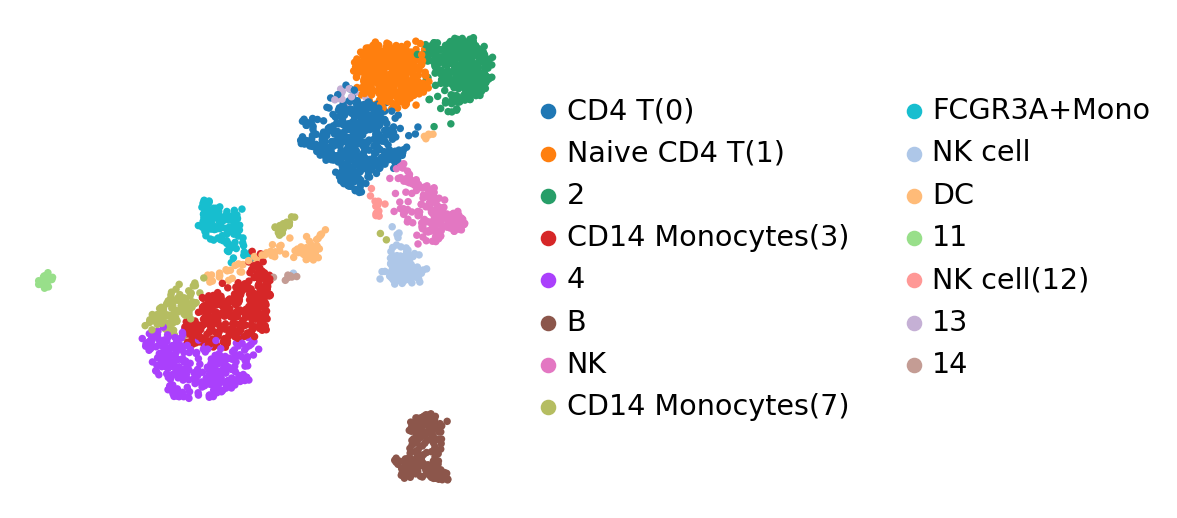

In [ ]:
sc.pl.umap(cdata, color='leiden', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


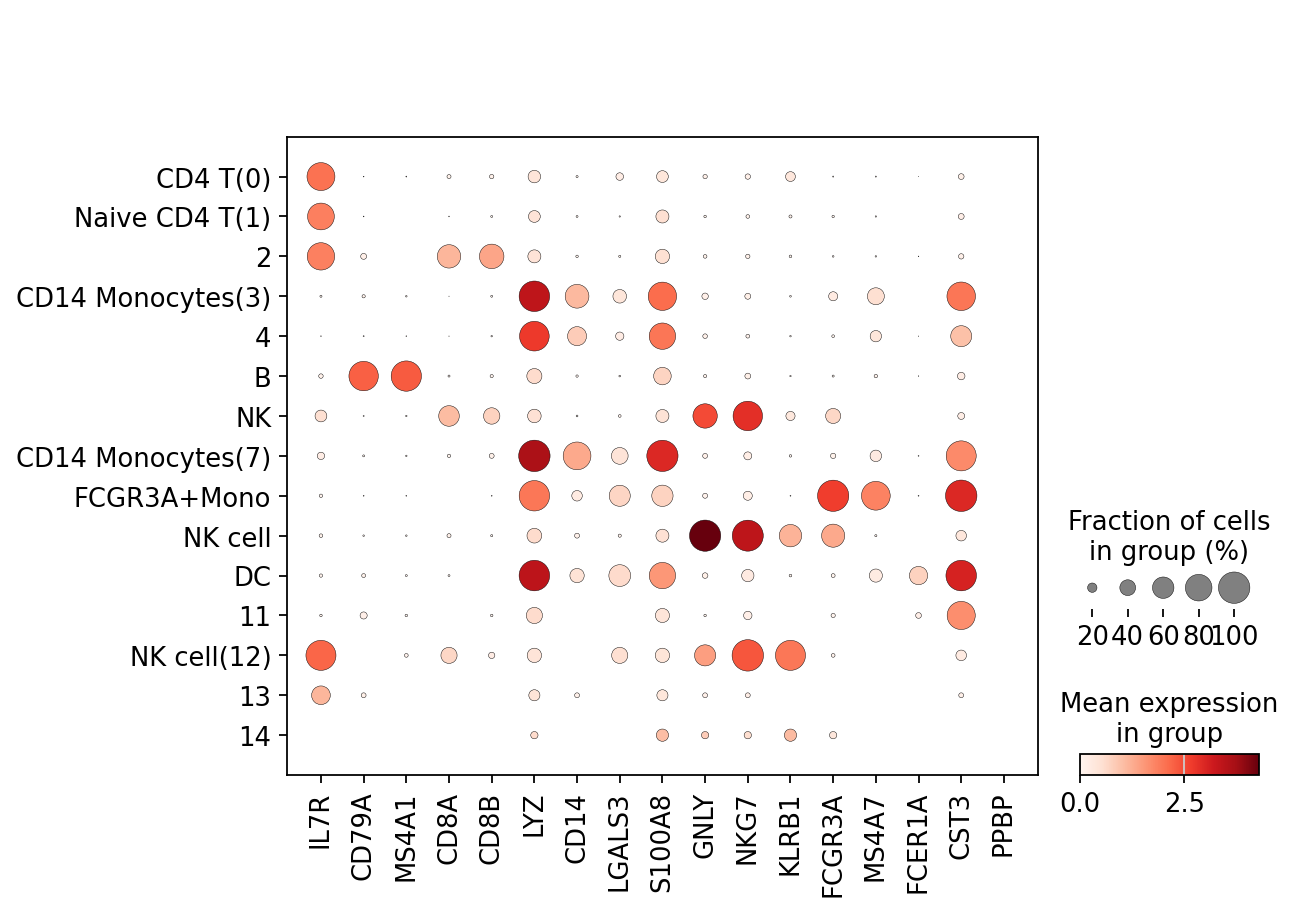

In [ ]:
sc.pl.dotplot(cdata, marker_genes, groupby='leiden');

There is also a very compact violin plot.

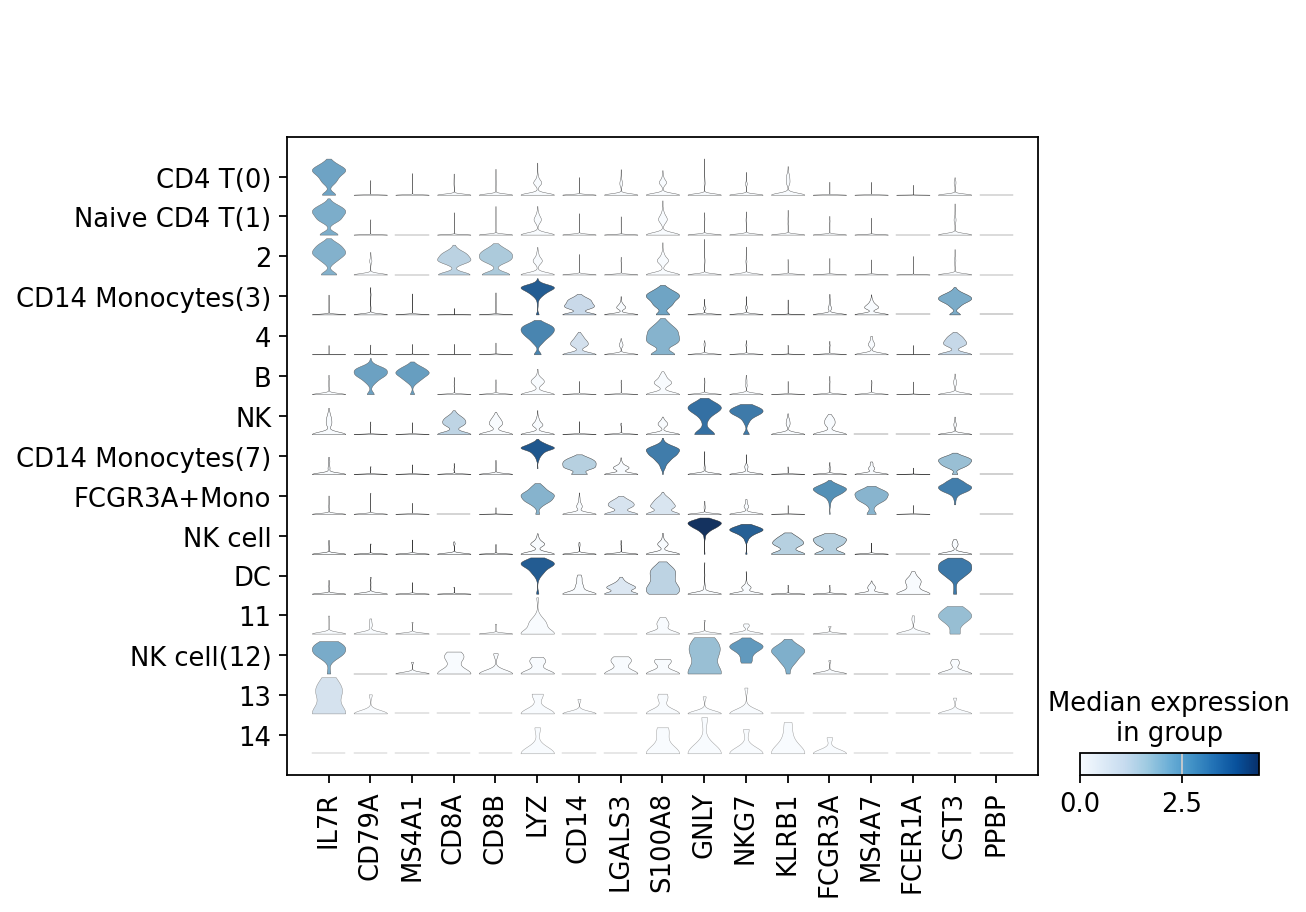

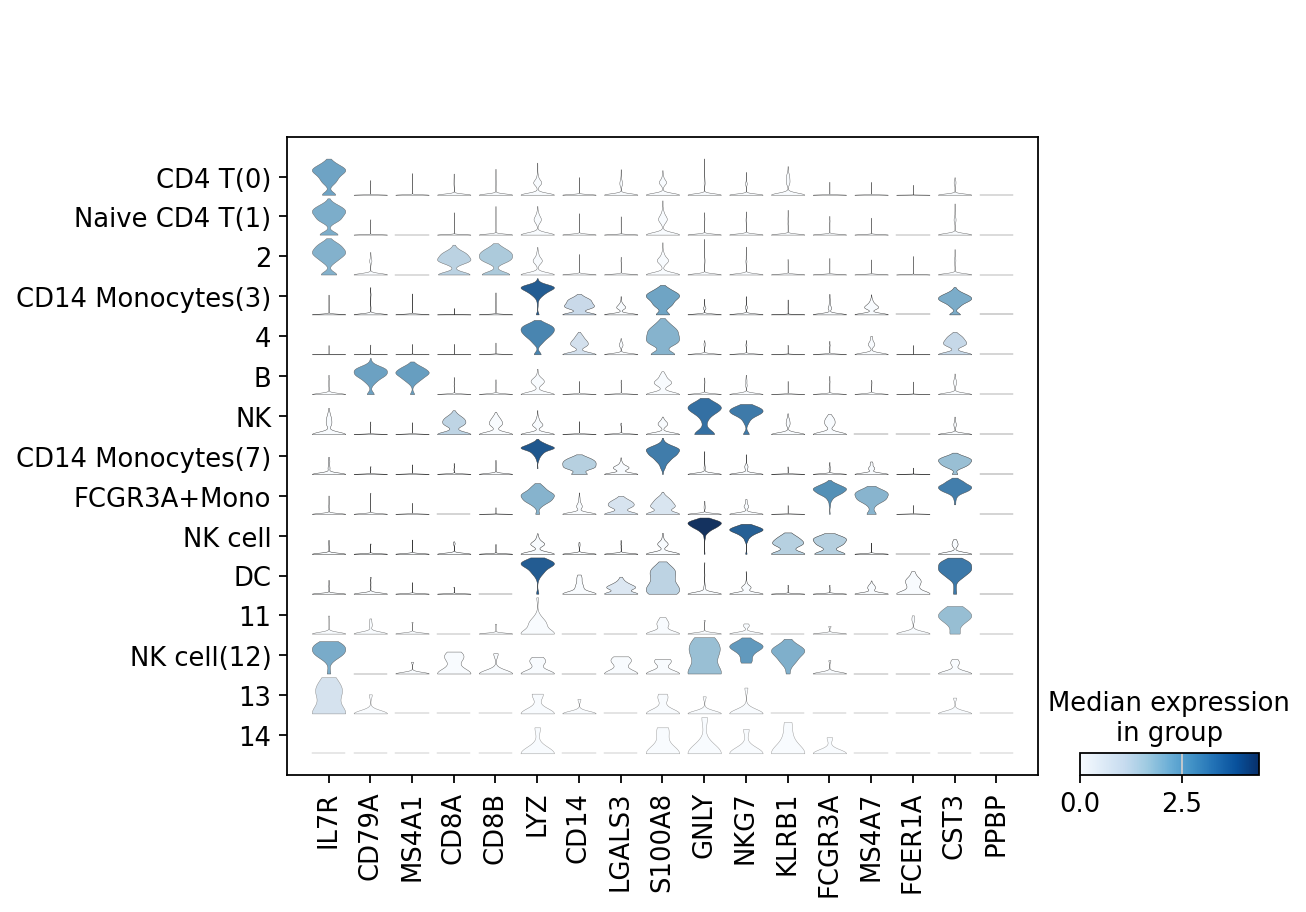

In [ ]:
sc.pl.stacked_violin(cdata, marker_genes, groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumlated the following annotations.

In [ ]:
adata

AnnData object with n_obs × n_vars = 2674 × 6889
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
cdata

AnnData object with n_obs × n_vars = 2652 × 4403
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'rank_genes_groups', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

    'CD4 T(0)','Naive CD4 T(1)','2','CD14 Monocytes(3)','4','B','NK','CD14 Monocytes(7)','FCGR3A+Mono or DC','NK cell', 'CD14 Monocytes or DC',
    '11','NK cell(12)','13','14'

In [ ]:
# Create a dictionary to map cluster names from scRNA-seq to scATAC-seq
cluster_map = {
    'CD4 T(0)': 'CD4 T',
    'Naive CD4 T(1)': 'Naive CD4 T',
    '2': 'unknown',
    'CD14 Monocytes(3)': 'CD14 Monocytes',
    '4': 'unknown',
    'B': 'B',
    'NK': 'NK',
    'CD14 Monocytes(7)': 'CD14 Monocytes',
    'FCGR3A+Mono': 'FCGR3A+Mono',
    'NK cell': 'NK',
    'DC': 'DC',
    '11': 'unknown',
    'NK cell(12)': 'NK',
    '13': 'unknown',
    '14': 'unknown'
}

# Map the cluster names from scRNA-seq to scATAC-seq
adata.obs['leiden'] = cdata.obs['leiden'].map(cluster_map)

In [ ]:
adata.obs['leiden']

AAACAGCCAAATATCC-1                NK
AAACAGCCAGGAACTG-1    CD14 Monocytes
AAACAGCCAGGCTTCG-1           unknown
AAACCAACACCTGCTC-1                 B
AAACCAACAGATTCAT-1                NK
                           ...      
TTTGTGGCATTAGCCA-1       Naive CD4 T
TTTGTGGCATTGCGAC-1                NK
TTTGTGTTCCGCCTAT-1             CD4 T
TTTGTGTTCCGTGACA-1                NK
TTTGTTGGTAGGTTTG-1               NaN
Name: leiden, Length: 2674, dtype: object

In [ ]:
 cdata.obs['leiden']

AAACAGCCAAATATCC-1              NK cell
AAACAGCCAGGAACTG-1    CD14 Monocytes(3)
AAACAGCCAGGCTTCG-1                    4
AAACCAACACCTGCTC-1                    B
AAACCAACAGATTCAT-1                   NK
                            ...        
TTTGTGGCATCCGTAA-1                    B
TTTGTGGCATTAGCCA-1       Naive CD4 T(1)
TTTGTGGCATTGCGAC-1              NK cell
TTTGTGTTCCGCCTAT-1             CD4 T(0)
TTTGTGTTCCGTGACA-1              NK cell
Name: leiden, Length: 2652, dtype: category
Categories (15, object): ['CD4 T(0)', 'Naive CD4 T(1)', '2', 'CD14 Monocytes(3)', ..., '11',
                          'NK cell(12)', '13', '14']

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


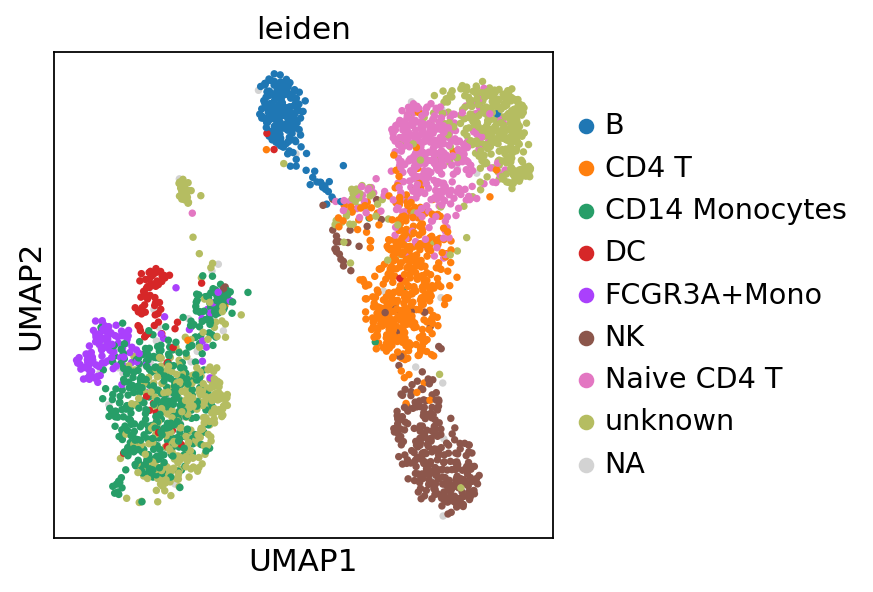

In [ ]:
sc.pl.umap(adata, color='leiden',save='pcatest')

In [ ]:
with open('ddata.pickle', 'wb') as f:
    pickle.dump(cdata, f)